In [ ]:
import pandas as pd

In [ ]:
# mounting drive to read data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Parspec_PDF/training_file_preprocessed_complete_pdf.csv')
train_df.head()

ID                                  text_preprocessed  labels
0  P-0  features different color and beam configuratio...       1
1  P-1  recommended use architectural landscaping gene...       1
2  P-1  weatherproof junction box weather proof cover ...       1
3  P-1  theweatherproof cable connector attach a weath...       1
4  P-1  with four anchor mount the fixture using two f...       1

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Parspec_PDF/test_file_preprocessed.csv')
test_df.head()

ID                                                URL  label  \
0  TP0  https://cdn.currentlighting.com/site/specsheet...      0   
1  TP1  https://cdn.currentlighting.com/site/specsheet...      0   
2  TP2  https://cdn.currentlighting.com/site/specsheet...      0   
3  TP3  https://www.assets.signify.com/is/content/Sign...      0   
4  TP4  https://www.assets.signify.com/is/content/Sign...      0   

                                                text  \
0  Synchron AC Power System Suggested Specificati...   
1  Synchron AC Power System Suggested Specificati...   
2  Synchron AC Power System Suggested Specificati...   
3  LXF / LXT Lexington Lumen Tables StreetworksPS...   
4  LXF / LXT Lexington Lumen Tables StreetworksPS...   

                                   text_preprocessed  
0  synchron ac power system suggested specificati...  
1  synchron ac power system suggested specificati...  
2  synchron ac power system suggested specificati...  
3  lxf lxt lexington lumen tables page amnominal ...  
4  lxf lxt lexington lumen tables page amnominal ...

In [ ]:
train_df['labels'].value_counts()

0    1535
1    1442
Name: labels, dtype: int64

# Model Training Prep

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
train_df.head()

ID                                  text_preprocessed  labels
0  P-0  features different color and beam configuratio...       1
1  P-1  recommended use architectural landscaping gene...       1
2  P-1  weatherproof junction box weather proof cover ...       1
3  P-1  theweatherproof cable connector attach a weath...       1
4  P-1  with four anchor mount the fixture using two f...       1

In [ ]:
#using transformers library from hugging face
import transformers
from transformers import BertTokenizer, BertForSequenceClassification

# using the bert base uncased tokenizer for converting the words to tokens
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# train_df = train_df[~train_df['text_preprocessed'].isnull()].copy(deep=True)

In [ ]:
long_text = train_df['text_preprocessed'].values
labels = train_df['labels'].values
input_ids = [] #input ids contain the sentence token to refer with bert vocabulary whihc has 30k rows (words)and 768 feature
attention_masks = [] # attention masks will have 1 for words and 0 for padding [PAD], so the model will skip padding values and gives importance to the reset

# For every sentence...
for text in long_text:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        # padding='longest',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt'     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', long_text[0])
print('Token IDs:', input_ids[0])
print("Tokenized:", tokenizer.convert_ids_to_tokens(tokenizer.encode(long_text[0])))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  features different color and beam configurations available aluminum alloy housing high heat dissipation performance universal power supply easy installation warranty electrical input vac etl listed led dual lightled dual light decors usa llcphone salesdecorsusacoma v ailable colors blue green amber warm white cool white red purpledecors led dual lightled dual light decors usa llcphone
Token IDs: tensor([  101,  2838,  2367,  3609,  1998,  7504, 22354,  2800, 13061, 17564,
         3847,  2152,  3684,  4487, 18719, 24952,  2239,  2836,  5415,  2373,
         4425,  3733,  8272, 10943,  2100,  5992,  7953, 12436,  2278,  3802,
         2140,  3205,  2419,  7037,  2422,  3709,  7037,  2422, 25545,  2015,
         3915, 11775,  9864,  4341,  3207, 27108, 13203, 22684,  2863,  1058,
         9932, 20470,  2571,  6087,  2630,  2665,  8994,  4010,  2317,  4658,
         2317,  2417,  6379,  3207, 27108,  2015,  2419,  7037,  2422,  3709,
         7037,  2422, 25545,  2015,  3915, 1

In [ ]:
from torch.utils.data import TensorDataset, random_split

# combine the training inputs into a TensorDatasets
dataset = TensorDataset(input_ids, attention_masks, labels)

# Creating a 80-20 split for train and validation
train_size=int(0.70 * len(dataset))
val_size=len(dataset)-train_size

# Divide the dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5}, training samples'.format(train_size))
print('{:>5}, validation samples'. format(val_size))

 2083, training samples
  894, validation samples


In [ ]:
from torch.utils.data.sampler import BatchSampler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# batch size can be 16 or 32 or 64, use 16 or lower if there is an issue in gpu memory issue (Runtime Error: CUDA memory )
batch_size=16

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

In [ ]:
# BertForSequenceClassification
import torch
torch.cuda.empty_cache()

from transformers import BertForSequenceClassification, AdamW, BertConfig

model=BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # The bert-base-uncased is about 400 MB, the bert-base-uncased has 12 layers and bert-large-uncased have 24 layers
    num_labels=2, # number of labels [1: Yes Lighting, 0: No Not Lighting]
    output_attentions = False, # will not return attentions
    output_hidden_states=False # will not return hidden states
)

model.cuda() # passing the model to gpu with cuda

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Model parameters
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# AdamW is a lib from Hugging face similar to adam optimizer
optimizer = AdamW(model.parameters(),
                  lr=2e-5, #0.000002, Learning Rate
                  eps = 1e-8 #0.000000001,  Adam's epsilon for numerical stability
                  )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs=4

total_steps = len(train_dataloader) * epochs

#create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = total_steps
)

In [ ]:
import numpy as np
# function to find the accuracy while model training
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat==labels_flat)/len(labels_flat)

In [ ]:
import time
import datetime
def format_time(elapsed):
    """
  Takes a time in seconds and returns a string hh:mm:ss
  """
    elapsed_rounded = int(round((elapsed)))

  #fromat as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 32

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    ### Training ###

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        mod = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += mod['loss'].item()

        # Perform a backward pass to calculate the gradients.
        mod['loss'].backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    ###    Validation   ###

    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            mod = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += mod['loss'].item()

        # Move logits and labels to CPU
        logits = mod['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    50  of    131.    Elapsed: 0:01:14.
  Batch   100  of    131.    Elapsed: 0:02:28.

  Average training loss: 0.40
  Training epcoh took: 0:03:13

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.20
  Validation took: 0:00:31

======== Epoch 2 / 4 ========
Training...
  Batch    50  of    131.    Elapsed: 0:01:14.
  Batch   100  of    131.    Elapsed: 0:02:28.

  Average training loss: 0.16
  Training epcoh took: 0:03:13

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.18
  Validation took: 0:00:31

======== Epoch 3 / 4 ========
Training...
  Batch    50  of    131.    Elapsed: 0:01:14.
  Batch   100  of    131.    Elapsed: 0:02:28.

  Average training loss: 0.08
  Training epcoh took: 0:03:12

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.15
  Validation took: 0:00:31

======== Epoch 4 / 4 ========
Training...
  Batch    50  of    131.    Elapsed: 0:01:14.
  Batch   100  of    131.    Elapsed: 0:

In [ ]:
import pandas as pd

In [ ]:
# Training Summary
# Display floats with two decimal places.

pd.set_option('display.precision', 2)


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               0.40         0.20           0.93       0:03:13         0:00:31
2               0.16         0.18           0.94       0:03:13         0:00:31
3               0.08         0.15           0.95       0:03:12         0:00:31
4               0.04         0.16           0.96       0:03:13         0:00:31

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

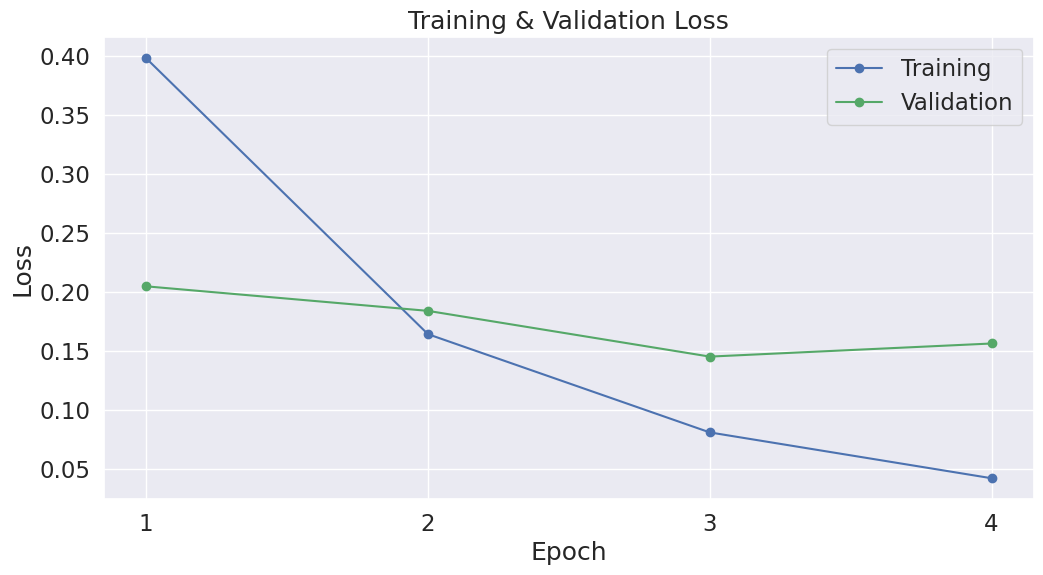

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import datetime;

# ct stores current time
ct = datetime.datetime.now()
time_stamp = str(ct)[:19]

In [ ]:
# Saving the model
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(f'/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_{time_stamp}')
tokenizer.save_pretrained(f'/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_{time_stamp}')

('/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_2023-12-08 18:18:11/tokenizer_config.json',
 '/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_2023-12-08 18:18:11/special_tokens_map.json',
 '/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_2023-12-08 18:18:11/vocab.txt',
 '/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_2023-12-08 18:18:11/added_tokens.json')

In [ ]:
import torch
import transformers
from transformers import BertForSequenceClassification, BertTokenizer

In [ ]:
model_path = f'/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_{time_stamp}'

In [ ]:
print(r'{0}'.format(model_path))

/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_2023-12-08 18:18:11


In [ ]:
#loading the saved model
# model=BertForSequenceClassification.from_pretrained(r'/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_2023-12-08 11:07:59')
model=BertForSequenceClassification.from_pretrained(r'{0}'.format(model_path))

In [ ]:
#loading the saved model tokenizer
# tokenizer=BertTokenizer.from_pretrained(r'/content/drive/MyDrive/Parspec_PDF/models/Bert_Base_Uncased_PDF_Classification_Light_2023-12-08 11:07:59')
tokenizer=BertTokenizer.from_pretrained(r'{0}'.format(model_path))

In [ ]:
import re
import string

import nltk
from nltk.corpus import stopwords
# Text Cleaning
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    if text == 'Error_Files':
      return text
    else:
      text = text.lower()
      text = re.sub('\[.*?\]', '', text)
      text = re.sub('https?://\S+|www\.\S+', '', text)
      text = re.sub('<.*?>+', '', text)
      text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
      text = re.sub('\n', '', text)
      text = re.sub('\w*\d\w*', '', text)
      return text

# Text Preprocessing
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    if text=='Error_Files':
      return text
    else:
      tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
      nopunc = clean_text(text)
      tokenized_text = tokenizer.tokenize(nopunc)
      #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
      combined_text = ' '.join(tokenized_text)
      return combined_text

In [ ]:
#prediction function
def prediction(data):
    data = text_preprocessing(data)
    batch = tokenizer(data, padding=True, truncation=True,max_length=512,return_tensors="pt")
    with torch.no_grad():
        outputs=model(**batch)
        labels_ids = torch.argmax(outputs.logits,dim=1)
        #print(labels_ids)
        labels=[model.config.id2label[label_id] for label_id in labels_ids.tolist()]
        #print(labels)
        label_lst=[]
        for label in labels:
            if label=='LABEL_0':
                label_lst.append(0)
            elif label=='LABEL_1':
                label_lst.append(1)
        return label_lst[0]

In [ ]:
test_df.iloc[15]

ID                                                                TP15
URL                  https://www.assets.signify.com/is/content/Sign...
label                                                                1
text                 \n\n\n\n\n\n\n\n...
text_preprocessed      cooper lighting solutions cdcaejoge rkedcarecae
Name: 15, dtype: object

In [ ]:
test_df['text_preprocessed'].iloc[15]

'cooper lighting solutions cdcaejoge rkedcarecae'

In [ ]:
test_pred = prediction(data=test_df['text_preprocessed'].iloc[15])

In [ ]:
test_pred

0

In [ ]:
test_df.head()

ID                                                URL  label  \
0  TP0  https://cdn.currentlighting.com/site/specsheet...      0   
1  TP1  https://cdn.currentlighting.com/site/specsheet...      0   
2  TP2  https://cdn.currentlighting.com/site/specsheet...      0   
3  TP3  https://www.assets.signify.com/is/content/Sign...      0   
4  TP4  https://www.assets.signify.com/is/content/Sign...      0   

                                                text  \
0  Synchron AC Power System Suggested Specificati...   
1  Synchron AC Power System Suggested Specificati...   
2  Synchron AC Power System Suggested Specificati...   
3  LXF / LXT Lexington Lumen Tables StreetworksPS...   
4  LXF / LXT Lexington Lumen Tables StreetworksPS...   

                                   text_preprocessed  
0  synchron ac power system suggested specificati...  
1  synchron ac power system suggested specificati...  
2  synchron ac power system suggested specificati...  
3  lxf lxt lexington lumen tables page amnominal ...  
4  lxf lxt lexington lumen tables page amnominal ...

In [ ]:
validation_data = test_df.drop(['text_preprocessed'], axis=1).copy(deep=True)

In [ ]:
validation_data.head()

ID                                                URL  label  \
0  TP0  https://cdn.currentlighting.com/site/specsheet...      0   
1  TP1  https://cdn.currentlighting.com/site/specsheet...      0   
2  TP2  https://cdn.currentlighting.com/site/specsheet...      0   
3  TP3  https://www.assets.signify.com/is/content/Sign...      0   
4  TP4  https://www.assets.signify.com/is/content/Sign...      0   

                                                text  
0  Synchron AC Power System Suggested Specificati...  
1  Synchron AC Power System Suggested Specificati...  
2  Synchron AC Power System Suggested Specificati...  
3  LXF / LXT Lexington Lumen Tables StreetworksPS...  
4  LXF / LXT Lexington Lumen Tables StreetworksPS...

In [ ]:
validation_data['prediction_label'] = validation_data['text'].apply(lambda x: prediction(x))

In [ ]:
validation_data.head()

ID                                                URL  label  \
0  TP0  https://cdn.currentlighting.com/site/specsheet...      0   
1  TP1  https://cdn.currentlighting.com/site/specsheet...      0   
2  TP2  https://cdn.currentlighting.com/site/specsheet...      0   
3  TP3  https://www.assets.signify.com/is/content/Sign...      0   
4  TP4  https://www.assets.signify.com/is/content/Sign...      0   

                                                text  prediction_label  
0  Synchron AC Power System Suggested Specificati...                 0  
1  Synchron AC Power System Suggested Specificati...                 0  
2  Synchron AC Power System Suggested Specificati...                 0  
3  LXF / LXT Lexington Lumen Tables StreetworksPS...                 1  
4  LXF / LXT Lexington Lumen Tables StreetworksPS...                 1

In [ ]:
# validation_data.to_csv('/content/drive/MyDrive/Parspec_PDF/validation_with_parspec_test_data.csv')
validation_data.to_csv(f'/content/drive/MyDrive/Parspec_PDF/validation_with_parspec_test_data_{time_stamp}.csv')

In [ ]:
# Classification Report to see the model performance
from sklearn.metrics import classification_report, confusion_matrix
class_report=classification_report(y_true=validation_data['label'],y_pred=validation_data['prediction_label'])

In [ ]:
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.52      0.67        60
           1       0.40      0.95      0.56        20

    accuracy                           0.62        80
   macro avg       0.68      0.73      0.62        80
weighted avg       0.83      0.62      0.65        80



In [ ]:
labels=validation_data['label'].unique().tolist()

In [ ]:
validation_data['label'].value_counts()

0    60
1    20
Name: label, dtype: int64

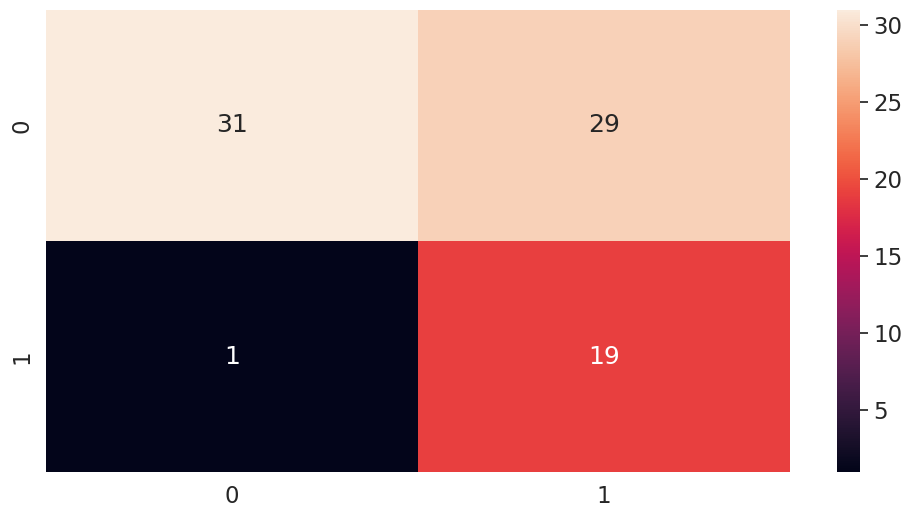

In [ ]:
ax=sns.heatmap(confusion_matrix(validation_data['label'],validation_data['prediction_label'],labels=labels), annot=True,fmt='.4g')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()